## Image segmentation with CamVid

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [3]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/home/ubuntu/.fastai/data/camvid/images'),
 PosixPath('/home/ubuntu/.fastai/data/camvid/valid.txt'),
 PosixPath('/home/ubuntu/.fastai/data/camvid/labels'),
 PosixPath('/home/ubuntu/.fastai/data/camvid/codes.txt')]

In [4]:
path_lbl = path/'labels'
path_img = path/'images'

## Subset classes

In [5]:
# path = Path('./data/camvid-small')

# def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

# codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
#     'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

# src = (SegmentationItemList.from_folder(path)
#        .split_by_folder(valid='val')
#        .label_from_func(get_y_fn, classes=codes))

# bs=8
# data = (src.transform(get_transforms(), tfm_y=True)
#         .databunch(bs=bs)
#         .normalize(imagenet_stats))

## Data

In [6]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/home/ubuntu/.fastai/data/camvid/images/Seq05VD_f01980.png'),
 PosixPath('/home/ubuntu/.fastai/data/camvid/images/0001TP_006840.png'),
 PosixPath('/home/ubuntu/.fastai/data/camvid/images/Seq05VD_f01710.png')]

In [7]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/home/ubuntu/.fastai/data/camvid/labels/0001TP_008640_P.png'),
 PosixPath('/home/ubuntu/.fastai/data/camvid/labels/0016E5_05640_P.png'),
 PosixPath('/home/ubuntu/.fastai/data/camvid/labels/0016E5_07650_P.png')]

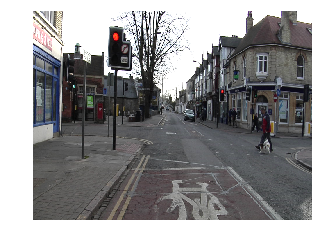

In [8]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [9]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

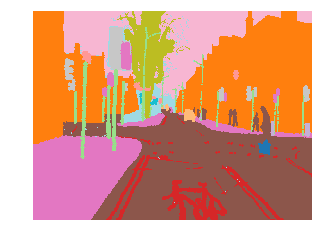

In [10]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [11]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[ 4,  4,  4,  ..., 21, 21, 21],
          [ 4,  4,  4,  ..., 21, 21, 21],
          [ 4,  4,  4,  ..., 21, 21, 21],
          ...,
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17]]]))

In [12]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## Datasets

In [16]:
src_size

array([720, 960])

In [17]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 16142MB of GPU RAM free


In [18]:
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [19]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [20]:
src

LabelLists;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: /home/ubuntu/.fastai/data/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: /home/ubuntu/.fastai/data/camvid/images;

Test: None

In [21]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

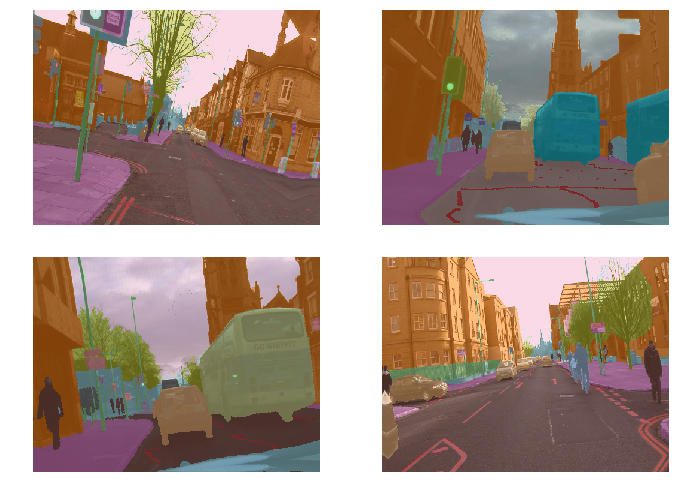

In [22]:
data.show_batch(2, figsize=(10,7))

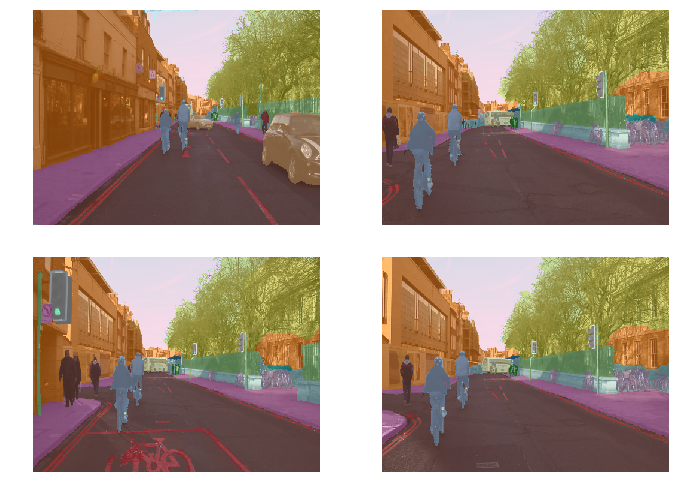

In [23]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [24]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [25]:
metrics=acc_camvid
# metrics=accuracy

In [26]:
wd=1e-2

In [27]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


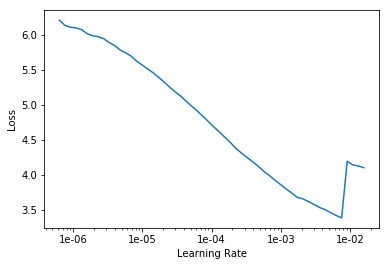

In [60]:
lr_find(learn)
learn.recorder.plot()

In [61]:
lr=3e-3

In [62]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.279748,0.787041,0.823911,00:34
1,0.854414,0.655439,0.833965,00:32
2,0.698453,0.570124,0.851705,00:32
3,0.622131,0.459599,0.877516,00:32
4,0.598161,0.490384,0.864331,00:32
5,0.657700,0.604764,0.857482,00:32
6,0.614785,0.463080,0.875150,00:32
7,0.555034,0.416557,0.878212,00:32
8,0.514732,0.372467,0.900551,00:32
9,0.455757,0.342471,0.901964,00:32


In [63]:
learn.save('stage-1')

In [64]:
learn.load('stage-1');

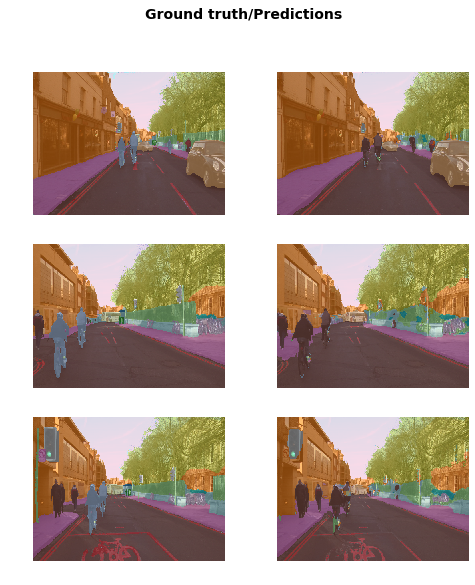

In [65]:
learn.show_results(rows=3, figsize=(8,9))

In [66]:
learn.unfreeze()

In [67]:
lrs = slice(lr/400,lr/4)

In [68]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.385864,0.329780,0.900955,00:34
1,0.381016,0.322844,0.903262,00:33
2,0.370702,0.317818,0.914679,00:33
3,0.359137,0.307123,0.912606,00:33
4,0.348002,0.304407,0.914549,00:33
5,0.347249,0.315008,0.909430,00:33
6,0.339320,0.307092,0.916678,00:33
7,0.335349,0.305811,0.912628,00:33
8,0.317466,0.296073,0.917698,00:33
9,0.315514,0.307615,0.916408,00:33


In [69]:
learn.save('stage-2');

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [28]:
learn.destroy()

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

this Learner object self-destroyed - it still exists, but no longer usable
using bs=3, have 15186MB of GPU RAM free


In [29]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [30]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [31]:
learn.load('stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


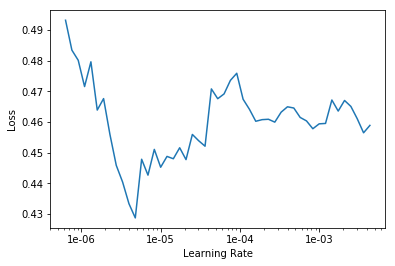

In [32]:
lr_find(learn)
learn.recorder.plot()

In [33]:
lr=1e-3

In [34]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.387531,0.338728,0.906224,01:33
1,0.353578,0.330667,0.911686,01:31
2,0.338674,0.320685,0.912677,01:31
3,0.332308,0.320215,0.911900,01:31
4,0.347561,0.302992,0.918027,01:31
5,0.341008,0.335922,0.914094,01:31
6,0.345662,0.300503,0.919243,01:31
7,0.338094,0.343206,0.911150,01:31
8,0.289025,0.280294,0.925812,01:31
9,0.236837,0.273027,0.926575,01:31


In [35]:
learn.save('stage-1-big')

In [36]:
learn.load('stage-1-big');

In [37]:
learn.unfreeze()

In [38]:
lrs = slice(1e-6,lr/10)

In [39]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.236085,0.269907,0.925931,01:34
1,0.227340,0.266164,0.926064,01:34
2,0.214720,0.283879,0.923077,01:35
3,0.210444,0.255706,0.930161,01:34
4,0.216311,0.264105,0.928011,01:34
5,0.196634,0.274971,0.925665,01:35
6,0.191053,0.271752,0.928511,01:34
7,0.196626,0.268834,0.927598,01:34
8,0.194514,0.262655,0.929228,01:34
9,0.189985,0.258462,0.930432,01:53


In [40]:
learn.save('stage-2-big')

In [41]:
learn.load('stage-2-big');

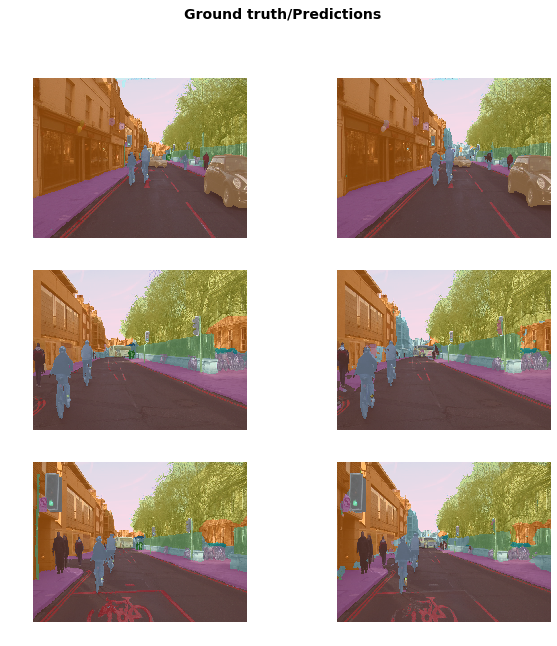

In [42]:
learn.show_results(rows=3, figsize=(10,10))

## fin